# 带约束条件的曲线拟合

我们经常遇到需要将上下波动较多的曲线拟合成一条平滑的曲线。

根据拟合的要求不同，可以有不同的方法。简单分成下面几类，并基于示例演示效果。

1. 把波动幅度弄小点，或者刨除周期性影响，如周中周末
    ```
    s.rolling(step=7).mean()
    ```
2. 需要光滑的曲线
    ```
    polyfit(degree=n)
    curvefit(objectFunc)
    ```
3. 需要限定条件的光滑曲线，如必须过某个点，或者取值范围必须在什么范围
    ```
    scipy.optimize.minimize
    ```

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import polyfit
from scipy.optimize import minimize

plt.style.use('fivethirtyeight')
%matplotlib inline

### 1. 原始曲线

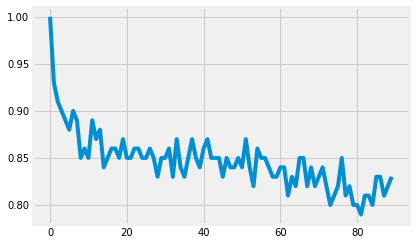

In [10]:
values = [1.  , 0.93, 0.91, 0.9 , 0.89, 0.88, 0.9 , 0.89, 0.85, 0.86, 0.85,
       0.89, 0.87, 0.88, 0.84, 0.85, 0.86, 0.86, 0.85, 0.87, 0.85, 0.85,
       0.86, 0.86, 0.85, 0.85, 0.86, 0.85, 0.83, 0.85, 0.85, 0.86, 0.83,
       0.87, 0.84, 0.83, 0.85, 0.87, 0.85, 0.84, 0.86, 0.87, 0.85, 0.85,
       0.85, 0.83, 0.85, 0.84, 0.84, 0.85, 0.84, 0.87, 0.84, 0.82, 0.86,
       0.85, 0.85, 0.84, 0.83, 0.83, 0.84, 0.84, 0.81, 0.83, 0.82, 0.85,
       0.85, 0.82, 0.84, 0.82, 0.83, 0.84, 0.82, 0.8 , 0.81, 0.82, 0.85,
       0.81, 0.82, 0.8 , 0.8 , 0.79, 0.81, 0.81, 0.8 , 0.83, 0.83, 0.81,
       0.82, 0.83]
s = pd.Series(values, index=np.arange(0,len(values)))
s.plot();

### 2. 移动平均

In [11]:
def rolling_test(s):
    plt.figure(figsize=(9,6))
    y = s.values
    x = np.arange(0, len(y), 1)
    plt.plot(x, y, 'b-',label='original data', alpha=0.6)
    for degree in np.arange(2,5,2):
        s1 = s.rolling(degree).mean()
        plt.plot(s1, label='step=%d' % degree)
    plt.legend()
    plt.title( 'rolling.mean')

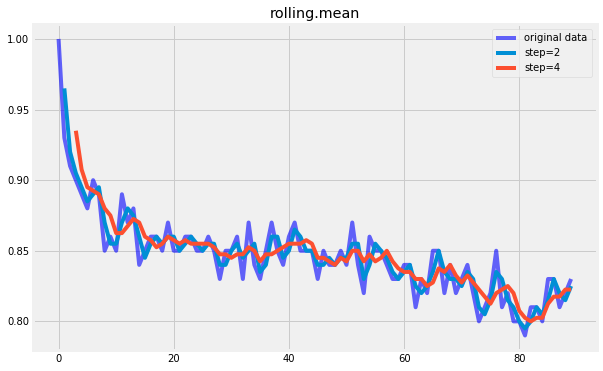

In [12]:
rolling_test(s)

### 3. 多项式拟合

In [15]:
def polyfit_test(s):
    plt.figure(figsize=(9,6))
    y = s.values
    x = np.arange(0, len(y), 1)
    plt.plot(x, y, 'b-',label='original data', alpha=0.6)
    for degree in np.arange(2,5):

        z1 = np.polyfit(x, y, degree)#用3次多项式拟合
        p1 = np.poly1d(z1)
        #print(p1) #在屏幕上打印拟合多项式
        yvals=p1(x)#也可以使用yvals=np.polyval(z1,x)
        plt.plot(x, yvals, label='degree=%d' % degree)
    plt.legend()#指定legend的位置,读者可以自己help它的用法
    plt.title( 'numpy.polyfit')

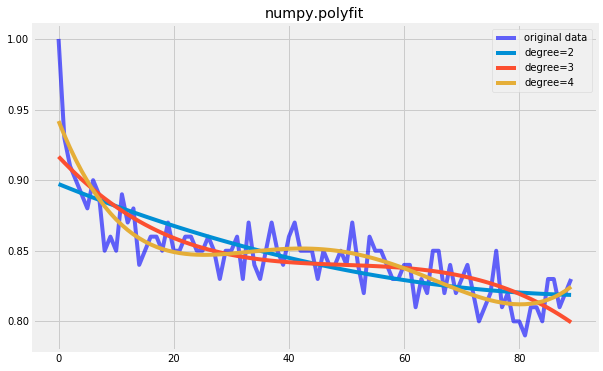

In [16]:
polyfit_test(s)

### 4. 任意曲线拟合

In [17]:
def curve_func(x, a, b, c, d):
    """
    拟合函数，多项式
    """
    return a - b*x + c*np.power(x,0.3) + d*np.power(x,0.7)

In [18]:
def curve_fit_with_no_condition(s, curve_func):
    """
    用curve_fit去拟合曲线
    @param: s是series
    @param: 要拟合的曲线函数
    @return: 拟合后的series
    """
    from scipy.optimize import curve_fit
    
    y = s.values
    x = s.index.values
    popt, pcov = curve_fit(curve_func, x, y)
    a, b, c, d = popt
    yvals = curve_func(x, a, b, c, d)
    return pd.Series(yvals, index=s.index)

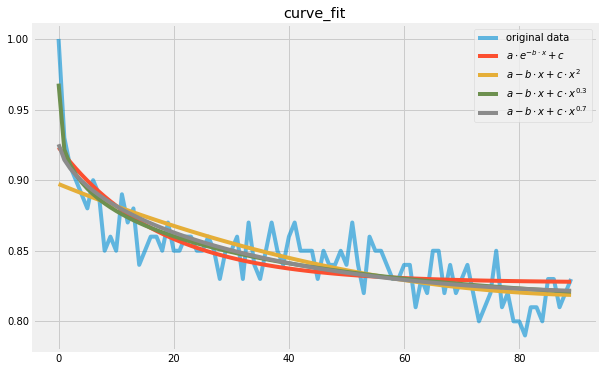

In [21]:
plt.figure(figsize=(9,6))
y = s.values
x = np.arange(0, len(y), 1)
plt.plot(s, label='original data', alpha=0.6)

def curve_func(x, a, b, c, d):
    return a * np.exp(-b * x) + c
plt.plot(curve_fit_with_no_condition(s, curve_func), label='$a\cdot e^{-b\cdot x} + c$')

def curve_func(x, a, b, c, d):
    return a - b*x + c*np.power(x,2)
plt.plot(curve_fit_with_no_condition(s, curve_func), label='$a - b \cdot x + c\cdot x^{2}$')

def curve_func(x, a, b, c, d):
    return a - b*x + c*np.power(x,0.3)
plt.plot(curve_fit_with_no_condition(s, curve_func), label='$a - b \cdot x + c\cdot x^{0.3}$')

def curve_func(x, a, b, c, d):
    return a - b*x + c*np.power(x,0.7)
plt.plot(curve_fit_with_no_condition(s, curve_func), label='$a - b \cdot x + c\cdot x^{0.7}$')

plt.legend()
plt.title('curve_fit');

### 5. 待约束条件的，任意曲线拟合 

In [22]:
def curve_func(x, a, b, c, d):
    """
    拟合函数，多项式
    """
    return a - b*x + c*np.power(x,0.3) + d*np.power(x,0.7)

In [23]:
def optimize_obj(p, x, y): 
    """
    条件拟合的优化目标函数，平方误差
    """
    a, b, c, d = p 
    return ((curve_func(x, a, b, c, d) - y)**2).sum() 

In [24]:
def curve_fit_with_conditions(s, index_condition, curve_funccs):
    """
    拟合曲线的同时，要求过指定的点
    用curve_fit + optimize去拟合
    本例中约束条件是过指定点，具体有index_condition决定
    param: s是series
    return: 拟合后的series
    """
    from scipy.optimize import minimize
    
    if len(index_condition) == 0:
        return curve_fit_with_no_condition(s, curve_func)
    
    x = s.index.values
    y = s.values
    
    print("condition: x=%.2f, y=%.2f" % (x[index_condition[0]], y[index_condition[0]]))
    
    # 约束条件
    cons = (
        {'type': 'eq', 
         'fun': lambda p: curve_func(x[index_condition[0]], p[0], p[1], p[2], p[3]) - y[index_condition[0]],
        },  
    ) 

    # 优化
    p0 = [1, 1, 1, 1] #initial estimate 
    sol = minimize(optimize_obj, p0, args=(x,y), constraints=cons) 

    a, b, c, d = sol.x
    yvals = curve_func(x, a, b, c, d)
    return pd.Series(yvals, index=s.index)

condition: x=0.00, y=1.00
condition: x=0.00, y=1.00
condition: x=0.00, y=1.00
condition: x=0.00, y=1.00
condition: x=0.00, y=1.00


/Users/liyuxia/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:8: RuntimeWarning: overflow encountered in exp
  
/Users/liyuxia/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:6: RuntimeWarning: overflow encountered in square
  


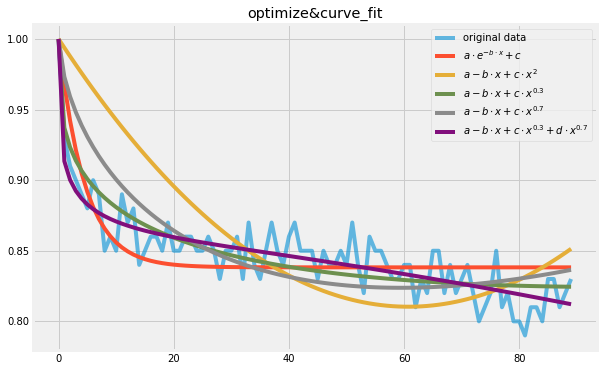

In [26]:
plt.figure(figsize=(9,6))

y = s.values
x = np.arange(0, len(y), 1)
plt.plot(s, label='original data', alpha=0.6)

def curve_func(x, a, b, c, d):
    return a * np.exp(-b * x) + c
plt.plot(curve_fit_with_conditions(s, [0], curve_func), label='$a\cdot e^{-b\cdot x} + c$')

def curve_func(x, a, b, c, d):
    return a - b*x + c*np.power(x,2)
plt.plot(curve_fit_with_conditions(s, [0], curve_func), label='$a - b \cdot x + c\cdot x^{2}$')

def curve_func(x, a, b, c, d):
    return a - b*x + c*np.power(x,0.3)
plt.plot(curve_fit_with_conditions(s, [0], curve_func), label='$a - b \cdot x + c\cdot x^{0.3}$')

def curve_func(x, a, b, c, d):
    return a - b*x + c*np.power(x,0.7)
plt.plot(curve_fit_with_conditions(s, [0], curve_func), label='$a - b \cdot x + c\cdot x^{0.7}$')

def curve_func(x, a, b, c, d):
    return a - b*x + c*np.power(x,0.3) + d*np.power(x,0.7)
plt.plot(curve_fit_with_conditions(s, [0], curve_func), label='$a - b \cdot x + c\cdot x^{0.3} + d\cdot x^{0.7}$')

plt.title('optimize&curve_fit')
plt.legend()

### 6. 取单调点

In [14]:
def monotonous(s, sign=1):
    """
    从波动的曲线中获取单调下降（或上升的数据点）
    @param s, series待处理数据
    @param sign, 1时如果要保留上升曲线，-1时保留下降曲线
    @return series, 处理后的s, 长度可能变化。
    """
    n = len(s.values)
    
    # 非单调的点上，mask设为False, 最后返回s[mask]
    mask = [True] * n
    
    start = 0 #需要取单调数据的起始点
    while start < n-1:
        # 如果单调，则start前进1，继续排查
        if sign * s[start+1] > sign * s[start]:
            start += 1
            continue
        
        # 如果不单调， 寻找相对于start单调的位置end， 并做处理
        curr = start + 1
        while curr < n:
            if sign * s[curr] > sign * s[start]:
                break;
            else:
                mask[curr] = False
                curr += 1
                
        # 结束跳出
        if curr == n - 1:
            break
         
        # 更新起始点
        start = curr 

    return s[mask]

Text(0.5,1,'选取单调点')

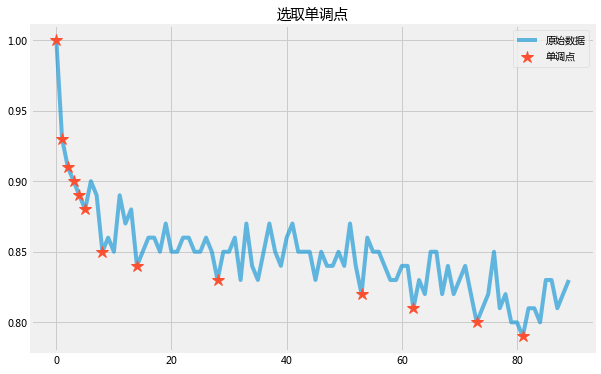

In [15]:
plt.figure(figsize=(9,6))
y = s.values
x = np.arange(0, len(y), 1)
plt.plot(s, label='原始数据', alpha=0.6)
plt.plot(monotonous(s, -1), '*', markersize=12, label='单调点')
plt.legend()
plt.title( '选取单调点');